### RTSR: Real-Time Traffic Sign Recognition Using YOLOv5 and CNN

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [41]:
meta_df = pd.read_csv("./data/Meta.csv")
test_df = pd.read_csv("./data/Test.csv")
train_df = pd.read_csv("./data/Train.csv")

In [42]:
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [43]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [44]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [45]:
# Show class distribution in the train and test datasets
train_class_distribution = train_df['ClassId'].value_counts()
test_class_distribution = test_df['ClassId'].value_counts()

In [46]:
(train_class_distribution, test_class_distribution)


(ClassId
 2     2250
 1     2220
 13    2160
 12    2100
 38    2070
 10    2010
 4     1980
 5     1860
 25    1500
 9     1470
 7     1440
 3     1410
 8     1410
 11    1320
 18    1200
 35    1200
 17    1110
 14     780
 31     780
 33     689
 15     630
 26     600
 28     540
 23     510
 30     450
 16     420
 6      420
 34     420
 22     390
 36     390
 40     360
 20     360
 21     330
 39     300
 29     270
 24     270
 32     240
 27     240
 41     240
 42     240
 37     210
 0      210
 19     210
 Name: count, dtype: int64,
 ClassId
 2     750
 1     720
 13    720
 38    690
 12    690
 4     660
 10    660
 5     630
 9     480
 25    480
 3     450
 8     450
 7     450
 11    420
 35    390
 18    390
 17    360
 31    270
 14    270
 15    210
 33    210
 26    180
 30    150
 16    150
 28    150
 6     150
 23    150
 22    120
 36    120
 34    120
 24     90
 29     90
 20     90
 40     90
 21     90
 39     90
 42     90
 32     60
 27     60
 41     6

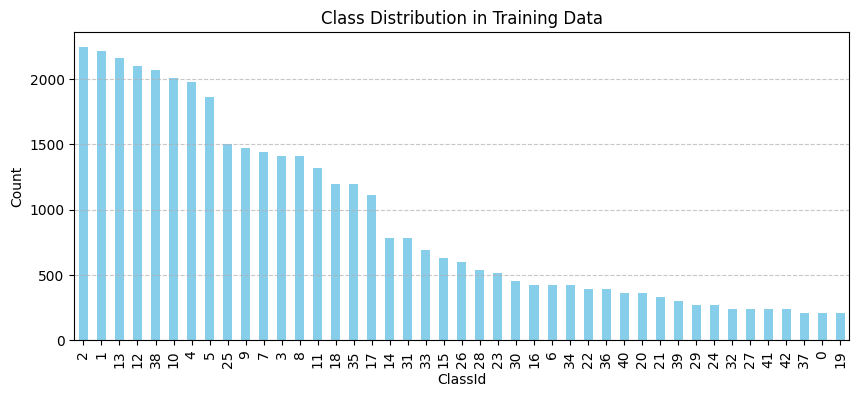

In [47]:
# Visualize class distribution in training data
plt.figure(figsize=(10, 4))
train_class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution in Training Data")
plt.xlabel("ClassId")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

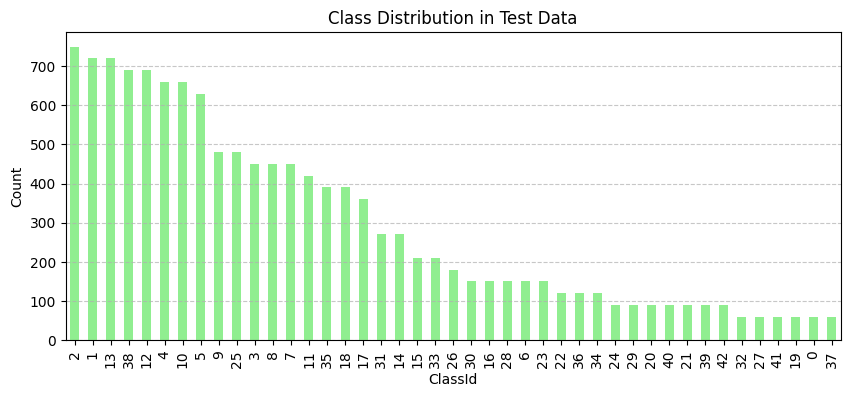

In [48]:
# Visualize class distribution in test data
plt.figure(figsize=(10, 4))
test_class_distribution.plot(kind="bar", color="lightgreen")
plt.title("Class Distribution in Test Data")
plt.xlabel("ClassId")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Image Preprocessing

In [49]:
import cv2
from tensorflow.keras.utils import to_categorical

In [50]:
# Constants
IMG_HEIGHT, IMG_WIDTH = 64, 64

In [51]:
base_path = "./data"

In [54]:
# Function to preprocess dataset
def preprocess_dataset(df):
    images = []
    labels = []
    
    for _, row in df.iterrows():
        # Full image path
        image_path = os.path.join(base_path, row["Path"])
        # Preprocess the image
        img = preprocess_image(image_path)
        if img is not None:
            # Append to the lists
            images.append(img)
            labels.append(row["ClassId"])
    
    # Convert lists to numpy arrays
    images = np.array(images, dtype="float32")
    labels = to_categorical(labels, num_classes=len(train_class_distribution))
    return images, labels

In [55]:
# Preprocess training and test datasets
train_images, train_labels = preprocess_dataset(train_df)
test_images, test_labels = preprocess_dataset(test_df)

# Output shapes for verification
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

Train Images Shape: (39209, 64, 64, 3)
Train Labels Shape: (39209, 43)
Test Images Shape: (12630, 64, 64, 3)
Test Labels Shape: (12630, 43)


### Data Augmentation

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [57]:
# Set up data augmentation
data_augmentor = ImageDataGenerator(
    rotation_range=30,       # Rotate images by up to 30 degrees
    width_shift_range=0.2,   # Shift width by up to 20%
    height_shift_range=0.2,  # Shift height by up to 20%
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Flip images horizontally
    brightness_range=[0.8, 1.2], # Random brightness adjustments
    fill_mode='nearest'      # Fill missing pixels after transformations
)

In [58]:
# Function to augment a single class
def augment_class(images, labels, target_count):
    current_count = len(images)
    augmented_images = []
    augmented_labels = []
    
    for _ in range(target_count - current_count):
        # Pick a random image to augment
        idx = np.random.randint(0, current_count)
        image = images[idx]
        label = labels[idx]
        # Augment the image
        augmented_image = data_augmentor.random_transform(image)
        augmented_images.append(augmented_image)
        augmented_labels.append(label)
    
    return np.array(augmented_images), np.array(augmented_labels)

In [60]:
# Address class imbalance
def balance_classes(images, labels):
    balanced_images = []
    balanced_labels = []
    
    # Group images and labels by class
    class_indices = np.argmax(labels, axis=1)
    unique_classes, class_counts = np.unique(class_indices, return_counts=True)
    max_count = max(class_counts)  # Target count for balancing
    
    for cls in unique_classes:
        class_images = images[class_indices == cls]
        class_labels = labels[class_indices == cls]
        
        # Augment the class if needed
        if len(class_images) < max_count:
            augmented_images, augmented_labels = augment_class(class_images, class_labels, max_count)
            class_images = np.concatenate((class_images, augmented_images), axis=0)
            class_labels = np.concatenate((class_labels, augmented_labels), axis=0)
        
        balanced_images.extend(class_images)
        balanced_labels.extend(class_labels)
    
    return np.array(balanced_images), np.array(balanced_labels)

# Apply data augmentation to balance training dataset
balanced_train_images, balanced_train_labels = balance_classes(train_images, train_labels)
# Output shapes for verification
print(f"Balanced Train Images Shape: {balanced_train_images.shape}")
print(f"Balanced Train Labels Shape: {balanced_train_labels.shape}")


Balanced Train Images Shape: (96750, 64, 64, 3)
Balanced Train Labels Shape: (96750, 43)


### Verify Class Distribution


In [61]:
import matplotlib.pyplot as plt

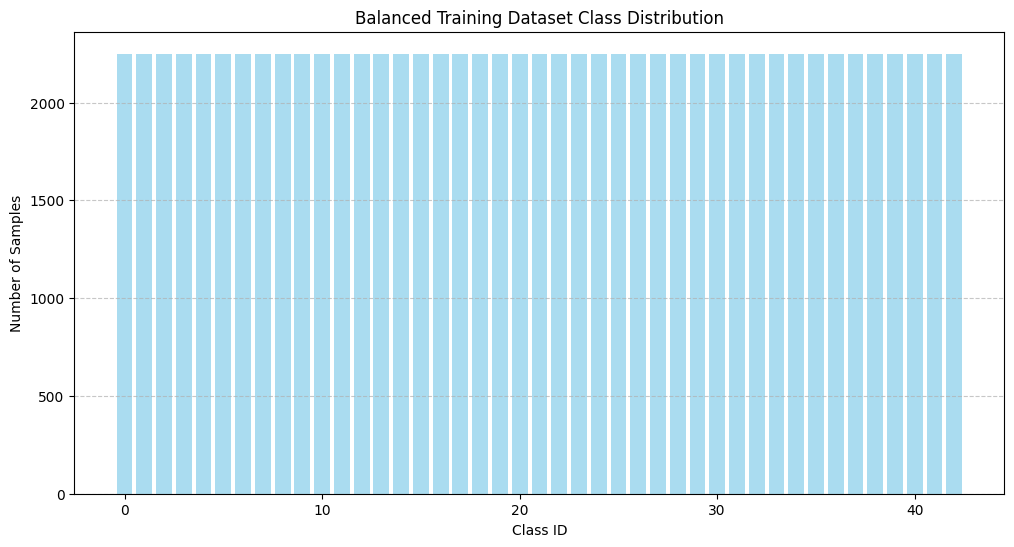

Class 0: 2250 samples
Class 1: 2250 samples
Class 2: 2250 samples
Class 3: 2250 samples
Class 4: 2250 samples
Class 5: 2250 samples
Class 6: 2250 samples
Class 7: 2250 samples
Class 8: 2250 samples
Class 9: 2250 samples
Class 10: 2250 samples
Class 11: 2250 samples
Class 12: 2250 samples
Class 13: 2250 samples
Class 14: 2250 samples
Class 15: 2250 samples
Class 16: 2250 samples
Class 17: 2250 samples
Class 18: 2250 samples
Class 19: 2250 samples
Class 20: 2250 samples
Class 21: 2250 samples
Class 22: 2250 samples
Class 23: 2250 samples
Class 24: 2250 samples
Class 25: 2250 samples
Class 26: 2250 samples
Class 27: 2250 samples
Class 28: 2250 samples
Class 29: 2250 samples
Class 30: 2250 samples
Class 31: 2250 samples
Class 32: 2250 samples
Class 33: 2250 samples
Class 34: 2250 samples
Class 35: 2250 samples
Class 36: 2250 samples
Class 37: 2250 samples
Class 38: 2250 samples
Class 39: 2250 samples
Class 40: 2250 samples
Class 41: 2250 samples
Class 42: 2250 samples


In [62]:
# Function to compute and visualize class distribution
def verify_class_distribution(labels, title="Class Distribution"):
    # Get class indices from one-hot encoded labels
    class_indices = np.argmax(labels, axis=1)
    # Count occurrences of each class
    class_counts = np.bincount(class_indices, minlength=labels.shape[1])
    
    # Plot the distribution
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(class_counts)), class_counts, color='skyblue', alpha=0.7)
    plt.title(title)
    plt.xlabel("Class ID")
    plt.ylabel("Number of Samples")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
    
    # Print distribution for reference
    for cls, count in enumerate(class_counts):
        print(f"Class {cls}: {count} samples")

# Verify class distribution for the balanced training dataset
verify_class_distribution(balanced_train_labels, title="Balanced Training Dataset Class Distribution")

### CNN Model Development

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [64]:
# Define CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Convolutional Layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Convolutional Layer 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Convolutional Layer 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Regularization
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [65]:
# Model Parameters
input_shape = (64, 64, 3)  # Image dimensions
num_classes = balanced_train_labels.shape[1]  # Number of classes

# Create CNN Model
cnn_model = create_cnn_model(input_shape, num_classes)

# Model Summary
cnn_model.summary()

# Train the CNN Model
history = cnn_model.fit(
    balanced_train_images, balanced_train_labels,
    validation_data=(test_images, test_labels),
    epochs=15,
    batch_size=64,
    verbose=1
)

# Evaluate Model Performance
loss, accuracy = cnn_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

C:\Users\yogen\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,643 (2.63 MB)

 Trainable params: 689,195 (2.63 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 627s 412ms/step - accuracy: 0.2185 - loss: 3.1123 - val_accuracy: 0.9306 - val_loss: 0.2325
Epoch 2/15
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 329s 177ms/step - accuracy: 0.3996 - loss: 2.2423 - val_accuracy: 0.9187 - val_loss: 0.2892
Epoch 3/15
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 180s 119ms/step - accuracy: 0.4094 - loss: 2.2028 - val_accuracy: 0.9492 - val_loss: 0.1990
Epoch 4/15
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 282s 187ms/step - accuracy: 0.4168 - loss: 2.1773 - val_accuracy: 0.9499 - val_loss: 0.2421
Epoch 5/15
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 406s 268ms/step - accuracy: 0.4185 - loss: 2.1699 - val_accuracy: 0.9314 - val_loss: 0.2678
Epoch 6/15
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 239s 158ms/step - accuracy: 0.4152 - loss: 2.1774 - val_accuracy: 0.9753 - val_loss: 0.1298
Epoch 7/15
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 194s 128ms/step - accuracy: 0.4219 - loss: 2.1553 - val_accuracy: 0.9736 - val_loss: 0.1248
Epoch 8/15
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 208s 138ms/step - ac

In [66]:
# Save the trained model
cnn_model.save("traffic_sign_classifier.h5")
print("Model saved successfully!")


Model saved successfully!


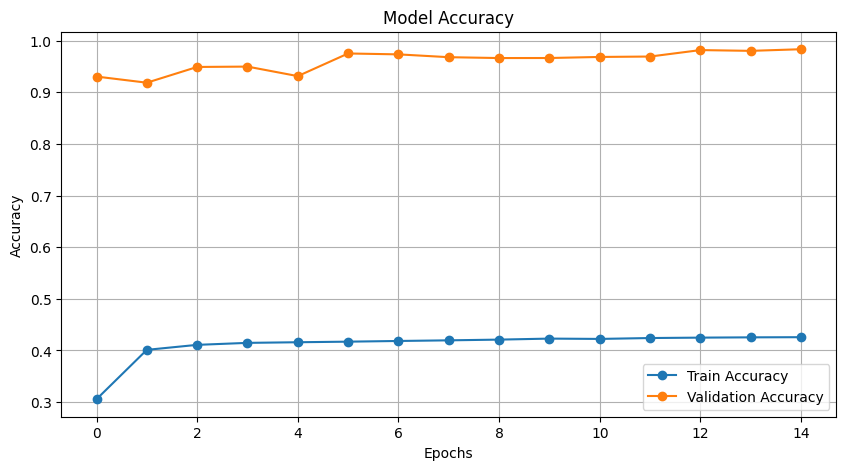

In [67]:
import matplotlib.pyplot as plt

# Plot training accuracy and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

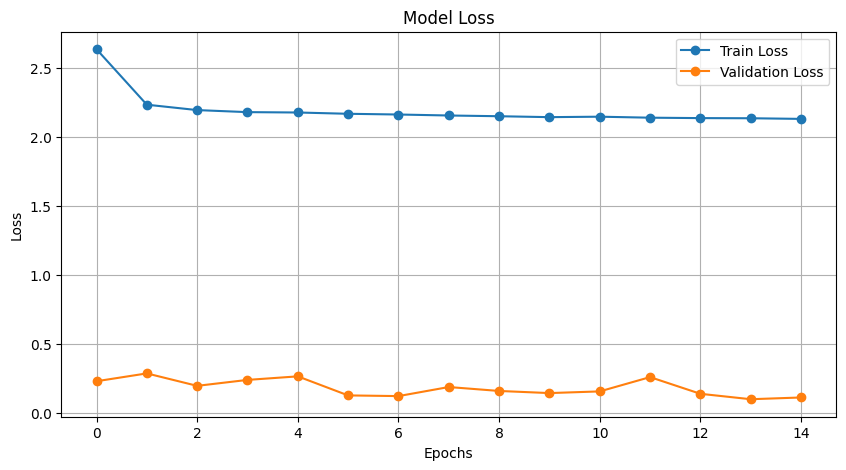

In [68]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


### Test with a Random Image and Simulate Snow

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


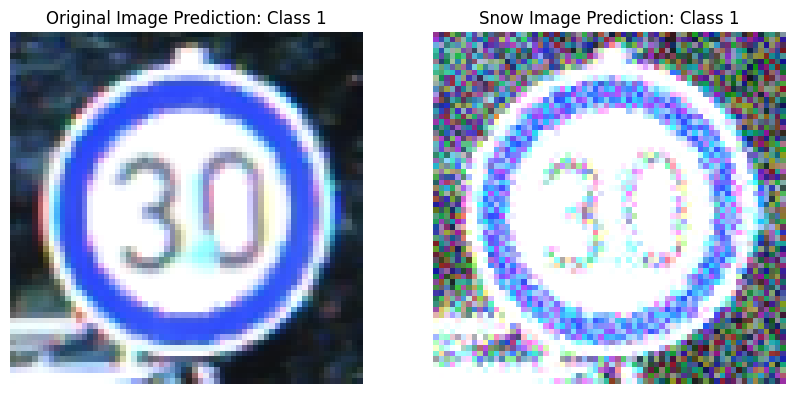

In [73]:
# Load and preprocess a random image
def test_with_random_image(image_path):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print("Failed to load image.")
        return
    # Resize to 64x64 and normalize
    original_image = cv2.resize(img, (64, 64)) / 255.0
    snow_image = add_snow_effect(original_image)
    
    # Add batch dimension for prediction
    input_image = np.expand_dims(original_image, axis=0)
    input_snow_image = np.expand_dims(snow_image, axis=0)

    # Predict using the model
    original_pred = cnn_model.predict(input_image)
    snow_pred = cnn_model.predict(input_snow_image)

    # Get class with highest probability
    original_class = np.argmax(original_pred)
    snow_class = np.argmax(snow_pred)

    # Plot images and predictions
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f"Original Image Prediction: Class {original_class}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(snow_image)
    plt.title(f"Snow Image Prediction: Class {snow_class}")
    plt.axis("off")

    plt.show()

# Function to simulate snow effect
def add_snow_effect(image, snow_intensity=0.5):
    # Convert normalized image (float32) to uint8
    image_uint8 = (image * 255).astype(np.uint8)
    # Generate a snow layer
    snow_layer = np.random.normal(size=image.shape, loc=255 * snow_intensity, scale=255 * (1 - snow_intensity))
    snow_layer = np.clip(snow_layer, 0, 255).astype(np.uint8)
    # Blend the image and the snow layer
    snow_image = cv2.addWeighted(image_uint8, 1.0, snow_layer, 0.5, 0)
    # Convert back to normalized (float32) for model prediction
    return snow_image / 255.0

# Test with the random image
random_image_path = "data/Test/00024.png"
test_with_random_image(random_image_path)


### YOLOv11 Development

In [92]:
from ultralytics import YOLO

In [93]:
# Load the pre-trained YOLOv11 model
model = YOLO('yolo11n.pt')  # Pre-trained weights for YOLOv11

# Train the YOLO model on your dataset
results = model.train(
    data='data.yaml',          # Path to your dataset configuration file
    epochs=50,                 # Number of training epochs
    imgsz=640,                 # Image size
    batch=16,                  # Batch size
    workers=4,                 # Number of data loader workers
    name='traffic_sign_yolov11'  # Experiment name
)

# Validate the YOLO model
metrics = model.val()
print("Validation Metrics:", metrics)


Ultralytics 8.3.48  Python-3.12.1 torch-2.5.1+cpu CPU (13th Gen Intel Core(TM) i7-1355U)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=traffic_sign_yolov1112, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

RuntimeError: Dataset 'data.yaml' error  
Dataset 'data.yaml' images not found , missing path 'D:\ECE-5831\Project\ece5831-2024-final-project\project\datasets\data\test\images'
Note dataset download directory is 'D:\ECE-5831\Project\ece5831-2024-final-project\project\datasets'. You can update this in 'C:\Users\yogen\AppData\Roaming\Ultralytics\settings.json'

In [ ]:
'''

# Address class imbalance
def balance_classes(images, labels):
    balanced_images = []
    balanced_labels = []
    
    # Group images and labels by class
    class_indices = np.argmax(labels, axis=1)
    unique_classes, class_counts = np.unique(class_indices, return_counts=True)
    max_count = max(class_counts)  # Target count for balancing
    
    for cls in unique_classes:
        class_images = images[class_indices == cls]
        class_labels = labels[class_indices == cls]
        
        # Augment the class if needed
        if len(class_images) < max_count:
            augmented_images, augmented_labels = augment_class(class_images, class_labels, max_count)
            class_images = np.concatenate((class_images, augmented_images), axis=0)
            class_labels = np.concatenate((class_labels, augmented_labels), axis=0)
        
        balanced_images.extend(class_images)
        balanced_labels.extend(class_labels)
    
    return np.array(balanced_images), np.array(balanced_labels)

# Apply data augmentation to balance training dataset
balanced_train_images, balanced_train_labels = balance_classes(train_images, train_labels)
# Output shapes for verification
print(f"Balanced Train Images Shape: {balanced_train_images.shape}")
print(f"Balanced Train Labels Shape: {balanced_train_labels.shape}")
'''

Balanced Train Images Shape: (96750, 64, 64, 3)
Balanced Train Labels Shape: (96750, 43)
